In [154]:
import numpy as np
import matplotlib.pyplot as plt

#add different folder
import sys
sys.path.append('../Code')
import noise as ns

# Plot results vs penalty

In [155]:
import moments_backend as est
import noise as nois
import optimisation as opt
import gymnasium as gym
import os
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import EvalCallback
#import monitor
from stable_baselines3.common.monitor import Monitor
import importlib
importlib.reload(nois)
importlib.reload(opt)
importlib.reload(est)






class data():
    def __init__(self, res, penalty):
        self.penalty = penalty
        self.actions = res.actions.flatten()
        self.rewards = res.rewards.flatten()
        self.mus = res.mus.flatten()
        self.oms = res.oms.flatten()
        self.stds = res.stds.flatten()*self.mus
        self.errors = self.mus-self.oms
        self.est_prob = np.sum(self.rewards==0)/len(self.rewards)
        self.succ_prob = np.sum(self.rewards==1)/len(self.rewards)
        self.fidelity = np.sum(self.rewards==1)/(np.sum(self.rewards<0)+np.sum(self.rewards==1))
        self.infidelity = np.sum(self.rewards<0)/(np.sum(self.rewards<0)+np.sum(self.rewards==1))

    def return_row(self):
        row = []
        row.append(self.penalty)
        row.append(np.mean(np.abs(self.errors)))
        row.append(self.est_prob)
        row.append(self.succ_prob)
        row.append(self.fidelity)
        return np.array(row)

2.3294507136590052
2.3294507136590052


/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_51287/1941744925.py:26: RuntimeWarning: invalid value encountered in log
  return a*np.log(b*x)+c


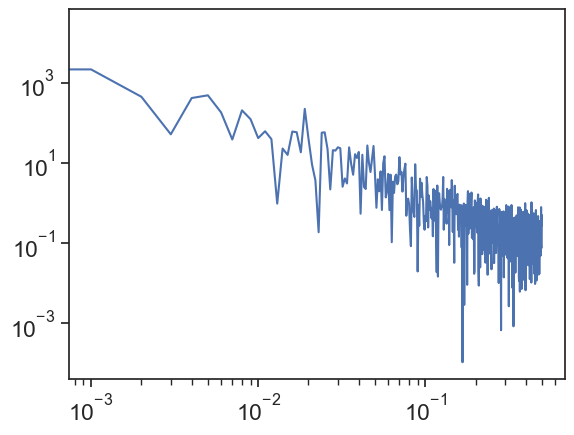

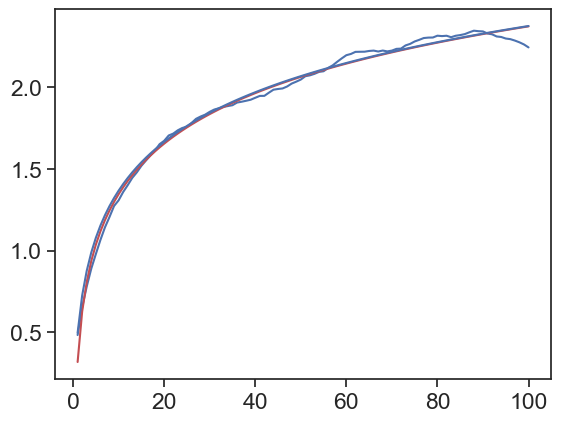

In [156]:
noise1f = nois.Over_f_noise(n_fluctuators = 10, S1 = 0.4*1e-2, sigma_couplings = 0.1, ommax = 1/10, ommin = 1/50000)
y = []
for k in range(1000):
    y.append(noise1f.update(1))
Sx,f =nois.get_spectrum(y,1,1000)
plt.figure()
plt.plot(Sx, f)
y = np.array(y)
plt.xscale("log")
plt.yscale("log")
plt.figure()
print(np.std(y))
stds = []
for k in range(100):
    k = k+1
    stds.append(np.mean(np.abs(y[k:] - y[:-k])))

print(np.std(y))


import numpy as np
from scipy.optimize import curve_fit
#fit the stds function to a log
# Define the form of the function you want to fit
def func(x, a, b,c):
    return a*np.log(b*x)+c

# Generate some data
x = np.arange(1, 101)
popt, pcov = curve_fit(func, x, stds)

a,b,c = popt
sig = lambda x: x + a*np.log(1+1/(np.exp((x-c)/a)/b))
y = [sig(0)]
for k in range(99):
    y.append(sig(y[-1]))

# Plot the data and the fitted model
plt.plot(x, stds, 'b', label='data')
plt.plot(x, func(x, *popt), 'r')
plt.plot(x,y)
cs = popt

In [161]:
om0=10
env = est.Moments_estimation_c(length = 1000, 
                                  om0 = om0, 
                                  noise = noise1f,
                                  max_time = 81,
                                  cs=cs,
                                  penalty = -1,
                                  time_step = 1,
                                  min_time = 1)
def policy_flip(n, **kwargs):
    return 0

def policy_random_p_c(n, state, *args, **kwargs):
    pflip = kwargs["x"][0]
    r = np.random.choice([0,1], p=[pflip,1-pflip])

    if r == 0:
        return 0
    else:
        return int(1/state[1]/state[0]*1e3/10)+1

def policy_interval_c(n,state, *args, **kwargs):
    x = kwargs["x"]
    Nflip = np.floor(x[0]) 
    Nest = np.floor(x[1])
    if (n % (Nflip+Nest)) < Nest:
        return int(1/state[1]/state[0]*1e3/10)+1
    elif (n % (Nflip+Nest)) < Nflip+Nest:
        return 0
    
policies = [policy_random_p_c, policy_interval_c]
xs = lambda p: [[1-p],[int(1/p),1]]
results = []
N = 50


probs = np.logspace(-2,np.log10(0.5),11)
#probs = [0.0001]
infidelitiesf = np.zeros((len(policies),len(probs)))
for prob in probs:
    print(prob)
    for n,policy in enumerate(policies):
        results.append(data(opt.game(N, env, policy = policy, x = xs(prob)[n]),0))
        infidelitiesf[n,probs==prob] = results[-1].infidelity

0.01
0.014787576366283134
0.021867241478865564
0.03233635032886786
0.04781762498950186
0.07071067811865475


/Users/krzywdaja/Documents/obsedian_test/Brain2/Science/Projects/Estimation-AI/presenation/../Code/noise.py:123: RuntimeWarning: overflow encountered in exp
  std = std + a*np.log(1+1/(np.exp((std-c)/a)/b))


0.10456395525912729
0.15462474735549586
0.22865252596366312
0.33812166890312056
0.5


402.0
695 293
0.2965587044534413
692.0
841 149
0.1505050505050505
413.0
692 279
0.28733264675592174
75.0
525 450
0.46153846153846156
701.0
825 124
0.13066385669125394
491.0
716 225
0.23910733262486716
35.0
457 422
0.4800910125142207
585.0
721 136
0.15869311551925322
450.0
539 89
0.14171974522292993


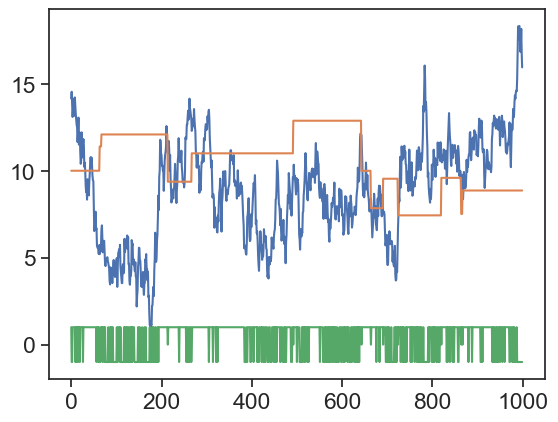

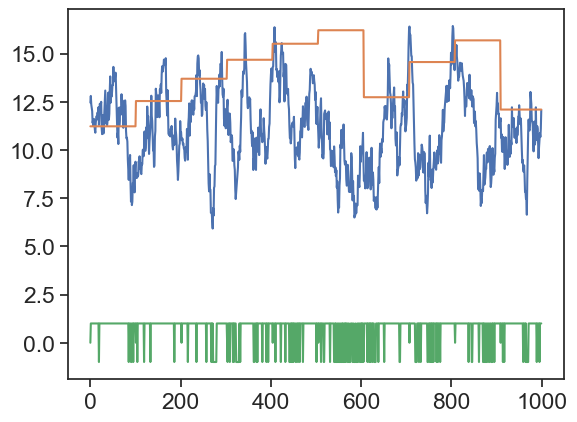

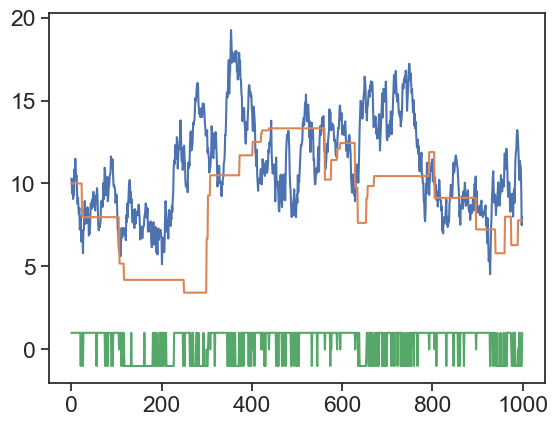

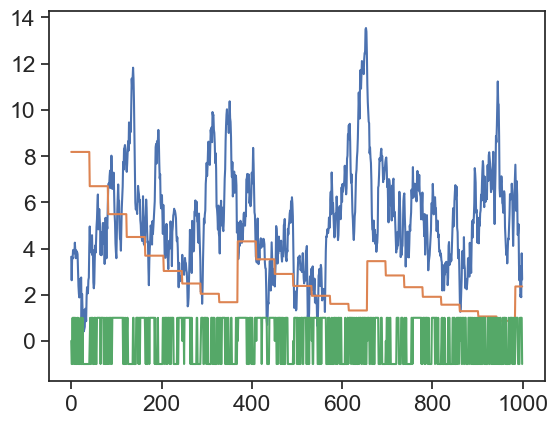

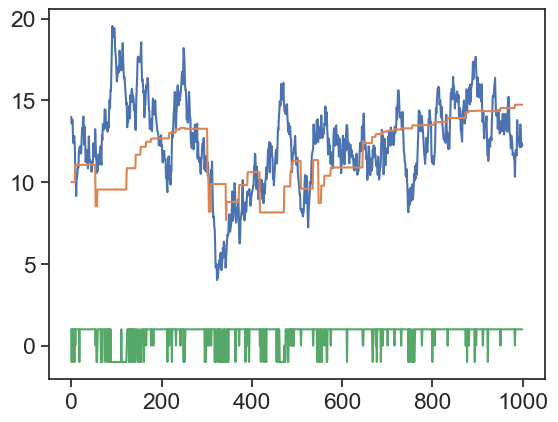

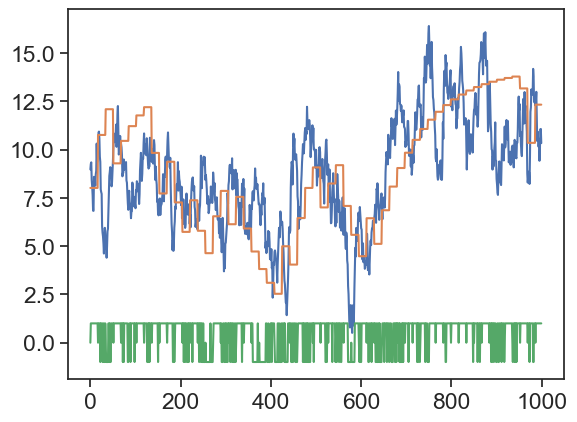

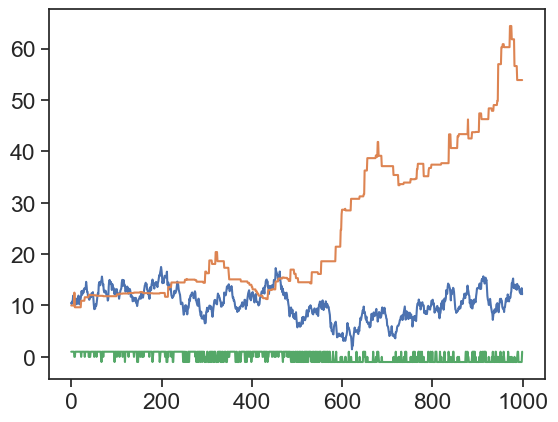

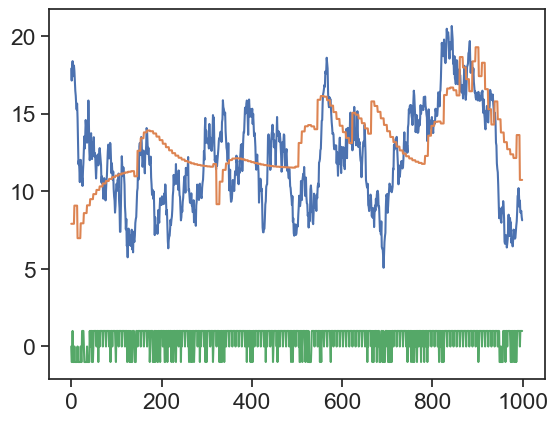

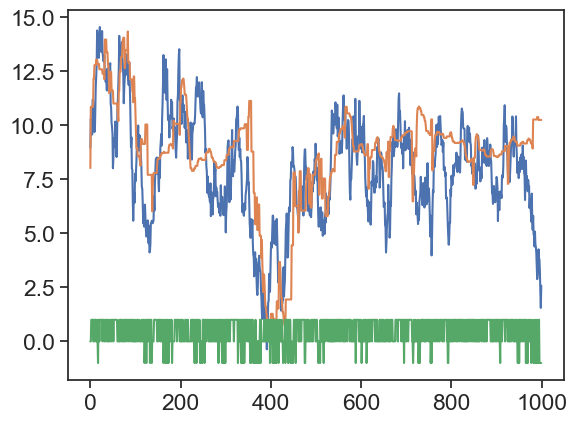

In [152]:
for k in range(9):
    print(np.sum(results[k].rewards))
    plt.figure()
    plt.plot(results[k].oms)
    plt.plot(results[k].mus)
    plt.plot(results[k].rewards)
    print(np.sum(results[k].rewards==1), np.sum(results[k].rewards==-1))
    print(np.sum(results[k].rewards==-1)/(np.sum(results[k].rewards==-1)+np.sum(results[k].rewards==1)))

In [58]:
for k in range(len(probs)):
    print(results[:][0].rewards)

[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]


ValueError: x and y must have same first dimension, but have shapes (50000,) and (1,)

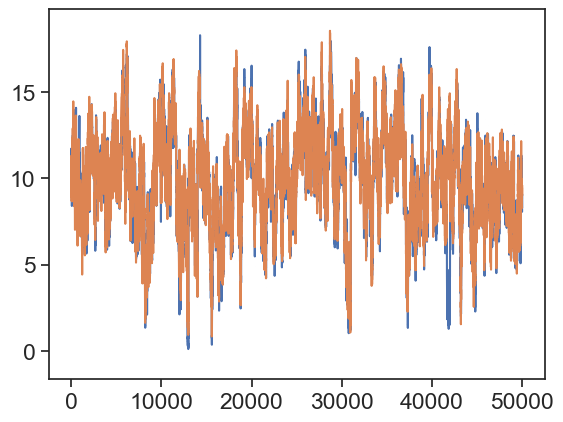

In [47]:
x = np.arange(len(results[1].oms))
plt.plot(x,results[-2].mus)
plt.plot(x,results[-2].oms)
plt.fill_between(x, y1 = results[-2].mus + results[-1].stds/2, 
                 y2 =results[-2].mus - results[-1].stds/2)

plt.plot(x,np.sum(results[0].rewards))
plt.xlim(0,400)


In [32]:
import seaborn as sns

In [148]:
def p_flip():
    s_om = 1/5
    x = 1
    f = lambda x: 1- (1/x)*(1-np.exp(-x))
    f(1)
    return 1/2-1/2*np.exp(-f(1)**2*(2*np.pi*np.pi)**2*s_om**2)    

In [149]:
p_flip()

0.439336257879791

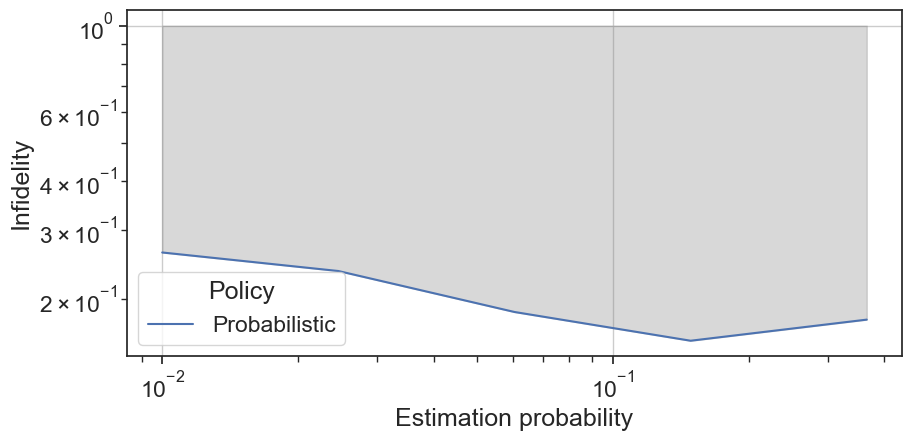

In [158]:
sns.set(font_scale=1.5,style="ticks")
plt.figure(figsize=(10, 4.5))
#plt.hlines(p_flip(),probs[0],probs[-2],color="k",linestyles="--",label="Always flip")  
ms = 10
plt.plot(probs[:-1],infidelitiesf[0,:-1],"-",ms=ms,label="Probabilistic")
#plt.plot(probs[:-1],infidelitiesf[1,:-1],"o-",ms=ms,label="Periodic")
plt.xscale("log")
plt.yscale("log")
plt.tick_params(axis='y', which='minor')
plt.xlabel("Estimation probability")
plt.ylabel("Infidelity")
plt.fill_between(probs[:-1],infidelitiesf[0,:-1],1,alpha=0.3, color="gray")
plt.grid(True)
#put log ticks
plt.legend(title="Policy", loc="lower left")
#plt.ylim(3*1e-4,1)


In [275]:
policies = []
for k in range(1):
    policies.append(data(results[k], 0))
    print(policies[k].est_prob)
    print(policies[k].fidelity)


0.04894
0.9712636426723866


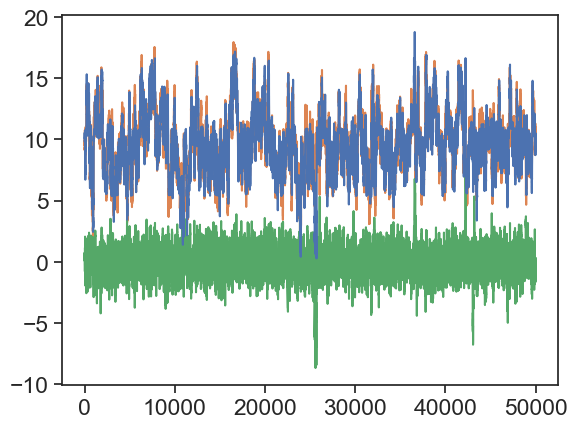

In [36]:
plt.plot(results[-1].mus,zorder=5)
plt.plot(results[-1].oms)
plt.plot(results[-1].errors)

In [172]:
data.return_row()

array([-0.01      ,  0.48831786,  0.05288   ,  0.93462   ,  0.98680209])

In [8]:


class data():
    def __init__(self, res, penalty):
        self.penalty = penalty
        self.actions = res.actions.flatten()
        self.rewards = res.rewards.flatten()
        self.mus = res.mus.flatten()
        self.oms = res.oms.flatten()
        self.stds = res.stds.flatten()*self.mus
        self.errors = self.mus-self.oms
        self.est_prob = np.sum(self.rewards==0)/len(self.rewards)
        self.succ_prob = np.sum(self.rewards==1)/len(self.rewards)
        self.fidelity = np.sum(self.rewards==1)/(np.sum(self.rewards<0)+np.sum(self.rewards==1))
        self.infidelity = np.sum(self.rewards<0)/(np.sum(self.rewards<0)+np.sum(self.rewards==1))

    def return_row(self):
        row = []
        row.append(self.penalty)
        row.append(np.mean(np.abs(self.errors)))
        row.append(self.est_prob)
        row.append(self.succ_prob)
        row.append(self.fidelity)
        return np.array(row)


In [461]:
om0 = 10
#penalty = [-0.1,-1,-5,-25]  #with ts = 1, max_time = 50
penalty = [-0.01,-50]  # with ts = 5, max_time = 81
results_t = []
N = 50
for p in penalty:
    env = est.Moments_estimation(length = 1000, 
                                  om0 = om0, 
                                  noise = noiseou,
                                  cs = 2,
                                  max_time = 500,
                                  penalty = p,
                                  time_step = 1,
                                  min_time = 1)
    #model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./ppo_bayes_tensorboard/", gamma = 1)
    model = model.load("../Code/logs2/t"+str(p)+"/best_model.zip")
   
    results_t.append(opt.game(N, env, model))

'''
penalty = [-0.01,-1,-10,-20,-50]
for p in penalty:
    env = est.Moments_estimation_c(length = 20000, 
                                om0 = om0, 
                                noise = noiseou,
                                cs = 2,
                                max_time = 500,
                                penalty = p,
                                time_step = 1,
                                min_time = 1)
    model = model.load("../Code/logs2/c"+str(p)+"/best_model.zip")
   
    results.append(opt.game(N, env, model))

'''


'\npenalty = [-0.01,-1,-10,-20,-50]\nfor p in penalty:\n    env = est.Moments_estimation_c(length = 20000, \n                                om0 = om0, \n                                noise = noiseou,\n                                cs = 2,\n                                max_time = 500,\n                                penalty = p,\n                                time_step = 1,\n                                min_time = 1)\n    model = model.load("../Code/logs2/c"+str(p)+"/best_model.zip")\n   \n    results.append(opt.game(N, env, model))\n\n'

In [466]:
datas_t = []
for result in results_t:
    datas_t.append(data(result,0))